In [41]:
import json
import os
from pathlib import Path
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

## 1. Load All Files by Folder

In [42]:
# Define the folders to analyze
folders = ['target', 'wayfair', 'zarahome']

def load_json_file(filepath):
    """Load a JSON file and return its contents"""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

def get_all_files_in_folder(folder_name):
    """Get all JSON files in a folder"""
    folder_path = Path(folder_name)
    if not folder_path.exists():
        return []
    return list(folder_path.glob('*.json'))

# Load all data
folder_data = {}
for folder in folders:
    files = get_all_files_in_folder(folder)
    folder_data[folder] = {}
    for file_path in files:
        data = load_json_file(file_path)
        if data:
            folder_data[folder][file_path.name] = data
    print(f"Loaded {len(folder_data[folder])} files from {folder}/")

Loaded 2 files from target/
Loaded 2 files from wayfair/
Loaded 3 files from zarahome/


## 2. Extract Key Fields from Each File

In [43]:
def extract_products(data):
    """Extract product information from JSON data"""
    products = []
    
    # Handle different JSON structures
    if isinstance(data, list):
        items = data
    elif isinstance(data, dict):
        # Try common keys
        items = data.get('products', data.get('items', data.get('data', [])))
        if not isinstance(items, list):
            items = [data]  # Single product object
    else:
        return products
    
    for item in items:
        if not isinstance(item, dict):
            continue
            
        product = {
            'url': item.get('url', item.get('product_url', item.get('link', ''))),
            'name': item.get('name', item.get('title', item.get('product_name', ''))),
            'price': item.get('price', item.get('current_price', item.get('sale_price', ''))),
            'image_url': item.get('image_url', item.get('image', item.get('thumbnail', '')))
        }
        products.append(product)
    
    return products

# Extract products from all files
extracted_data = {}
for folder, files in folder_data.items():
    extracted_data[folder] = {}
    for filename, data in files.items():
        products = extract_products(data)
        extracted_data[folder][filename] = products
        print(f"{folder}/{filename}: {len(products)} products")

target/cleaned_data.json: 3000 products
target/cleaned_target_data_2026-01-12T18-26-36.json: 2000 products
wayfair/cleaned_wayfair2_data_2026-01-10_22-44-01-180.json: 2055 products
wayfair/cleaned_wayfair_data.json: 2630 products
zarahome/cleaned_zarahome_data_2025-12-17_07-32-46-404.json: 287 products
zarahome/cleaned_zarahome_data_2026-01-01_11-54-37-460.json: 260 products
zarahome/cleaned_zarahome_data_2026-01-10_21-52-39-441.json: 260 products


## 3. Find Duplicates Within Each Folder

In [44]:
def find_duplicates_by_field(folder_name, field='url'):
    """Find duplicate products across files in a folder based on a specific field"""
    if folder_name not in extracted_data:
        return {}
    
    field_tracker = defaultdict(list)
    
    # Track which files contain each product (by field)
    for filename, products in extracted_data[folder_name].items():
        for product in products:
            field_value = product.get(field, '')
            if field_value:  # Only track non-empty values
                field_tracker[field_value].append({
                    'file': filename,
                    'product': product
                })
    
    # Find duplicates (appearing in multiple files)
    duplicates = {k: v for k, v in field_tracker.items() if len(v) > 1}
    
    return duplicates

# Analyze each folder
for folder in folders:
    if folder not in extracted_data or not extracted_data[folder]:
        continue
        
    print(f"\n{'='*60}")
    print(f"FOLDER: {folder}/")
    print(f"{'='*60}")
    
    # Find duplicates by URL
    url_duplicates = find_duplicates_by_field(folder, 'url')
    print(f"\n🔗 Duplicate URLs: {len(url_duplicates)}")
    
    # Find duplicates by name
    name_duplicates = find_duplicates_by_field(folder, 'name')
    print(f"📝 Duplicate Names: {len(name_duplicates)}")
    
    # Show a few examples
    if url_duplicates:
        print("\nExample URL duplicates:")
        for i, (url, occurrences) in enumerate(list(url_duplicates.items())[:3]):
            files = [occ['file'] for occ in occurrences]
            print(f"  {i+1}. Found in {len(files)} files: {', '.join(files)}")
            print(f"     URL: {url[:80]}...")


FOLDER: target/

🔗 Duplicate URLs: 1525
📝 Duplicate Names: 1497

Example URL duplicates:
  1. Found in 2 files: cleaned_data.json, cleaned_target_data_2026-01-12T18-26-36.json
     URL: https://www.target.com/p/ceylon-woven-counter-height-barstool-black-natural-thre...
  2. Found in 3 files: cleaned_data.json, cleaned_data.json, cleaned_target_data_2026-01-12T18-26-36.json
     URL: https://www.target.com/p/costway-freestanding-wooden-coat-tree-360-rotary-coat-r...
  3. Found in 2 files: cleaned_data.json, cleaned_target_data_2026-01-12T18-26-36.json
     URL: https://www.target.com/p/new-bedford-2-door-accent-cabinet-black-threshold-8482/...

FOLDER: wayfair/

🔗 Duplicate URLs: 40
📝 Duplicate Names: 270

Example URL duplicates:
  1. Found in 2 files: cleaned_wayfair2_data_2026-01-10_22-44-01-180.json, cleaned_wayfair_data.json
     URL: https://www.wayfair.com/bed-bath/pdp/williams-co-mattress-the-oxford-20-plush-13...
  2. Found in 2 files: cleaned_wayfair2_data_2026-01-10_22-44-01-

## 4. Calculate Similarity Between Files in Each Folder

In [45]:
def calculate_file_similarity(folder_name, field='url'):
    """Calculate similarity matrix between all files in a folder"""
    if folder_name not in extracted_data:
        return None, None
    
    files = list(extracted_data[folder_name].keys())
    if len(files) < 2:
        print(f"Only {len(files)} file(s) in {folder_name}, skipping similarity analysis")
        return None, None
    
    # Create sets of field values for each file
    file_sets = {}
    for filename, products in extracted_data[folder_name].items():
        field_values = set(p.get(field, '') for p in products if p.get(field, ''))
        file_sets[filename] = field_values
    
    # Calculate Jaccard similarity between all pairs
    similarity_matrix = []
    for file1 in files:
        row = []
        for file2 in files:
            set1 = file_sets[file1]
            set2 = file_sets[file2]
            
            if len(set1) == 0 and len(set2) == 0:
                similarity = 1.0
            elif len(set1) == 0 or len(set2) == 0:
                similarity = 0.0
            else:
                intersection = len(set1 & set2)
                union = len(set1 | set2)
                similarity = intersection / union if union > 0 else 0.0
            
            row.append(similarity)
        similarity_matrix.append(row)
    
    return similarity_matrix, files

# Calculate and display similarity for each folder
similarity_results = {}

for folder in folders:
    if folder not in extracted_data or not extracted_data[folder]:
        continue
        
    print(f"\n{'='*60}")
    print(f"SIMILARITY ANALYSIS: {folder}/")
    print(f"{'='*60}")
    
    # Calculate similarity based on URLs
    sim_matrix, file_names = calculate_file_similarity(folder, 'url')
    
    if sim_matrix and file_names:
        similarity_results[folder] = (sim_matrix, file_names)
        
        # Display as DataFrame
        df = pd.DataFrame(sim_matrix, index=file_names, columns=file_names)
        df = df.round(3)
        print("\nSimilarity Matrix (based on URLs):")
        print(df)


SIMILARITY ANALYSIS: target/

Similarity Matrix (based on URLs):
                                              cleaned_data.json  \
cleaned_data.json                                          1.00   
cleaned_target_data_2026-01-12T18-26-36.json               0.41   

                                              cleaned_target_data_2026-01-12T18-26-36.json  
cleaned_data.json                                                                     0.41  
cleaned_target_data_2026-01-12T18-26-36.json                                          1.00  

SIMILARITY ANALYSIS: wayfair/

Similarity Matrix (based on URLs):
                                                    cleaned_wayfair2_data_2026-01-10_22-44-01-180.json  \
cleaned_wayfair2_data_2026-01-10_22-44-01-180.json                                              1.000    
cleaned_wayfair_data.json                                                                       0.009    

                                                    cleaned_wayfair

## 5. Visualize Similarity Heatmaps

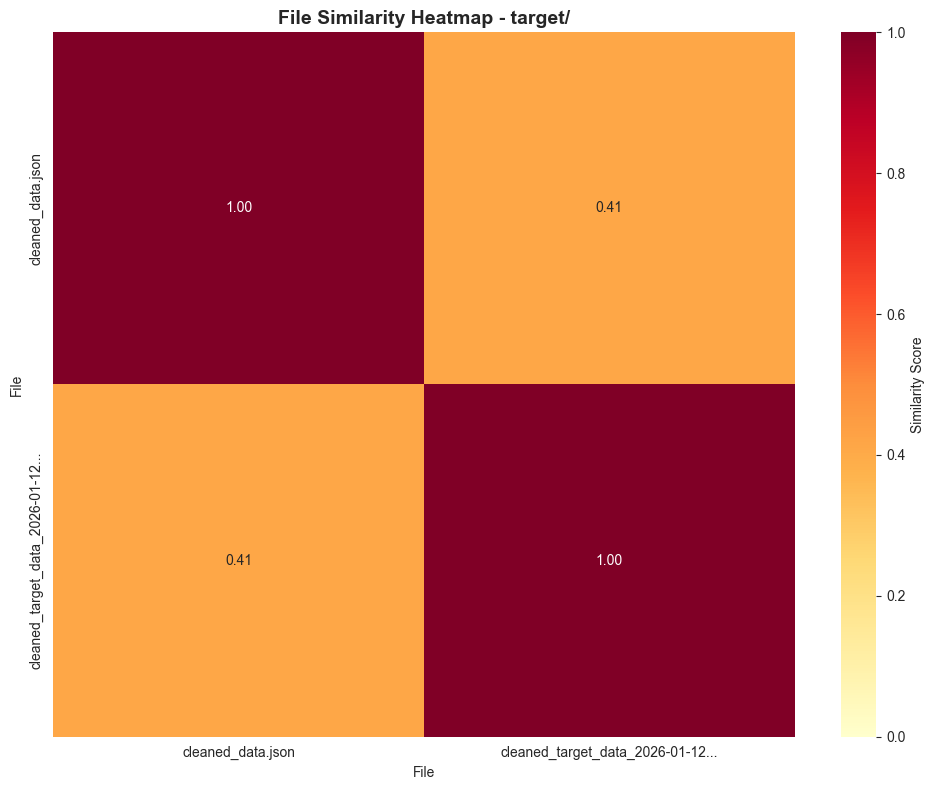

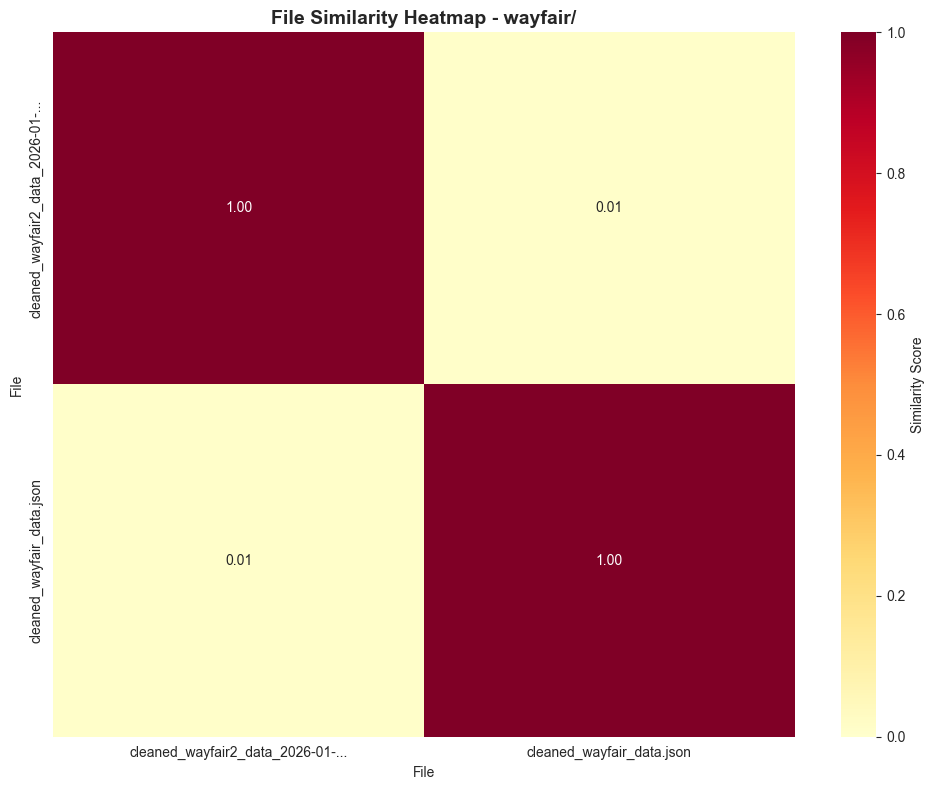

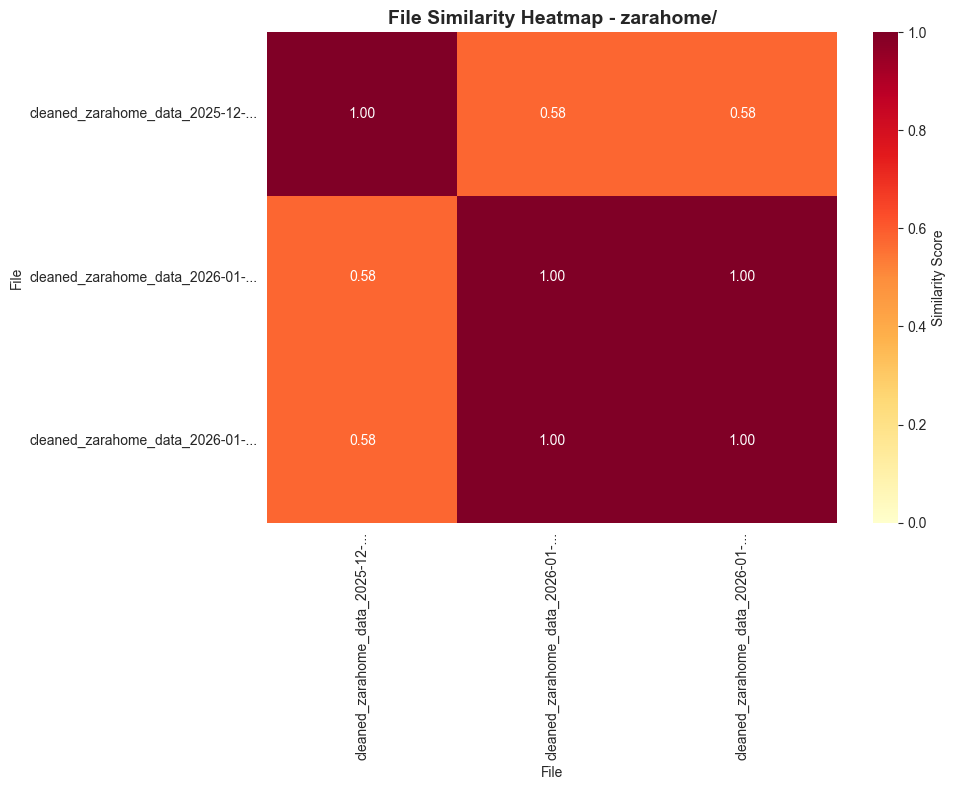

In [46]:
# Create heatmaps for each folder
for folder, (sim_matrix, file_names) in similarity_results.items():
    plt.figure(figsize=(10, 8))
    
    # Shorten file names for display
    short_names = [name[:30] + '...' if len(name) > 30 else name for name in file_names]
    
    df = pd.DataFrame(sim_matrix, index=short_names, columns=short_names)
    
    sns.heatmap(df, annot=True, fmt='.2f', cmap='YlOrRd', 
                cbar_kws={'label': 'Similarity Score'},
                vmin=0, vmax=1)
    
    plt.title(f'File Similarity Heatmap - {folder}/', fontsize=14, fontweight='bold')
    plt.xlabel('File')
    plt.ylabel('File')
    plt.tight_layout()
    plt.show()

## 6. Detailed Comparison Statistics

In [47]:
def detailed_file_comparison(folder_name):
    """Generate detailed comparison statistics for files in a folder"""
    if folder_name not in extracted_data:
        return
    
    print(f"\n{'='*60}")
    print(f"DETAILED COMPARISON: {folder_name}/")
    print(f"{'='*60}")
    
    files = list(extracted_data[folder_name].keys())
    
    # Collect all unique products by different fields
    all_urls = set()
    all_names = set()
    all_prices = set()
    all_images = set()
    
    stats = []
    
    for filename, products in extracted_data[folder_name].items():
        urls = set(p.get('url', '') for p in products if p.get('url', ''))
        names = set(p.get('name', '') for p in products if p.get('name', ''))
        prices = set(str(p.get('price', '')) for p in products if p.get('price', ''))
        images = set(p.get('image_url', '') for p in products if p.get('image_url', ''))
        
        all_urls.update(urls)
        all_names.update(names)
        all_prices.update(prices)
        all_images.update(images)
        
        stats.append({
            'File': filename,
            'Total Products': len(products),
            'Unique URLs': len(urls),
            'Unique Names': len(names),
            'Unique Prices': len(prices),
            'Unique Images': len(images)
        })
    
    df_stats = pd.DataFrame(stats)
    print("\nPer-File Statistics:")
    print(df_stats.to_string(index=False))
    
    print(f"\n\nFolder-wide Unique Values:")
    print(f"  Total Unique URLs: {len(all_urls)}")
    print(f"  Total Unique Names: {len(all_names)}")
    print(f"  Total Unique Prices: {len(all_prices)}")
    print(f"  Total Unique Images: {len(all_images)}")
    
    return df_stats

# Run detailed comparison for each folder
detailed_stats = {}
for folder in folders:
    if folder in extracted_data and extracted_data[folder]:
        detailed_stats[folder] = detailed_file_comparison(folder)


DETAILED COMPARISON: target/

Per-File Statistics:
                                        File  Total Products  Unique URLs  Unique Names  Unique Prices  Unique Images
                           cleaned_data.json            3000         2859          2815           1586           2800
cleaned_target_data_2026-01-12T18-26-36.json            2000         1984          1958            959           1978


Folder-wide Unique Values:
  Total Unique URLs: 3434
  Total Unique Names: 3416
  Total Unique Prices: 1940
  Total Unique Images: 3389

DETAILED COMPARISON: wayfair/

Per-File Statistics:
                                              File  Total Products  Unique URLs  Unique Names  Unique Prices  Unique Images
cleaned_wayfair2_data_2026-01-10_22-44-01-180.json            2055         2055          2007            901           2050
                         cleaned_wayfair_data.json            2630         2630          2488            930           2611


Folder-wide Unique Values:
  

## 7. Identify Unique vs Shared Products

In [48]:
def find_unique_and_shared(folder_name, field='url'):
    """Find products unique to each file and shared across files"""
    if folder_name not in extracted_data:
        return
    
    files = list(extracted_data[folder_name].keys())
    if len(files) < 2:
        print(f"Need at least 2 files for comparison in {folder_name}")
        return
    
    print(f"\n{'='*60}")
    print(f"UNIQUE vs SHARED: {folder_name}/")
    print(f"{'='*60}")
    
    # Get field values for each file
    file_values = {}
    for filename, products in extracted_data[folder_name].items():
        values = set(p.get(field, '') for p in products if p.get(field, ''))
        file_values[filename] = values
    
    # Find shared across all files
    all_files = list(file_values.values())
    shared_all = set.intersection(*all_files) if all_files else set()
    
    print(f"\n📊 Products shared across ALL files: {len(shared_all)}")
    
    # Find unique to each file
    print(f"\n🔍 Products unique to each file (not in any other file):")
    for filename, values in file_values.items():
        other_values = set()
        for other_file, other_vals in file_values.items():
            if other_file != filename:
                other_values.update(other_vals)
        
        unique = values - other_values
        print(f"  {filename}: {len(unique)} unique products")
    
    # Pairwise overlap
    if len(files) <= 5:  # Only show pairwise for small sets
        print(f"\n🔄 Pairwise overlaps:")
        for i, file1 in enumerate(files):
            for file2 in files[i+1:]:
                overlap = len(file_values[file1] & file_values[file2])
                print(f"  {file1} ∩ {file2}: {overlap} products")

# Analyze each folder
for folder in folders:
    if folder in extracted_data and extracted_data[folder]:
        find_unique_and_shared(folder, 'url')


UNIQUE vs SHARED: target/

📊 Products shared across ALL files: 1409

🔍 Products unique to each file (not in any other file):
  cleaned_data.json: 1450 unique products
  cleaned_target_data_2026-01-12T18-26-36.json: 575 unique products

🔄 Pairwise overlaps:
  cleaned_data.json ∩ cleaned_target_data_2026-01-12T18-26-36.json: 1409 products

UNIQUE vs SHARED: wayfair/

📊 Products shared across ALL files: 40

🔍 Products unique to each file (not in any other file):
  cleaned_wayfair2_data_2026-01-10_22-44-01-180.json: 2015 unique products
  cleaned_wayfair_data.json: 2590 unique products

🔄 Pairwise overlaps:
  cleaned_wayfair2_data_2026-01-10_22-44-01-180.json ∩ cleaned_wayfair_data.json: 40 products

UNIQUE vs SHARED: zarahome/

📊 Products shared across ALL files: 200

🔍 Products unique to each file (not in any other file):
  cleaned_zarahome_data_2025-12-17_07-32-46-404.json: 87 unique products
  cleaned_zarahome_data_2026-01-01_11-54-37-460.json: 0 unique products
  cleaned_zarahome_dat

## 8. Summary Report

In [49]:
print("\n" + "="*60)
print("OVERALL SUMMARY")
print("="*60)

for folder in folders:
    if folder not in extracted_data or not extracted_data[folder]:
        print(f"\n{folder}/: No data")
        continue
    
    num_files = len(extracted_data[folder])
    total_products = sum(len(products) for products in extracted_data[folder].values())
    
    # Count duplicates
    url_dups = len(find_duplicates_by_field(folder, 'url'))
    name_dups = len(find_duplicates_by_field(folder, 'name'))
    
    print(f"\n{folder.upper()}/")
    print(f"  Files: {num_files}")
    print(f"  Total Products (across all files): {total_products}")
    print(f"  Duplicate URLs across files: {url_dups}")
    print(f"  Duplicate Names across files: {name_dups}")
    
    if folder in similarity_results:
        sim_matrix, _ = similarity_results[folder]
        # Average similarity (excluding diagonal)
        n = len(sim_matrix)
        if n > 1:
            avg_sim = sum(sum(row) - 1 for row in sim_matrix) / (n * (n - 1))
            print(f"  Average file similarity: {avg_sim:.2%}")


OVERALL SUMMARY

TARGET/
  Files: 2
  Total Products (across all files): 5000
  Duplicate URLs across files: 1525
  Duplicate Names across files: 1497
  Average file similarity: 41.03%

WAYFAIR/
  Files: 2
  Total Products (across all files): 4685
  Duplicate URLs across files: 40
  Duplicate Names across files: 270
  Average file similarity: 0.86%

ZARAHOME/
  Files: 3
  Total Products (across all files): 807
  Duplicate URLs across files: 260
  Duplicate Names across files: 243
  Average file similarity: 71.76%


## 9. Product Count Comparison Visualizations

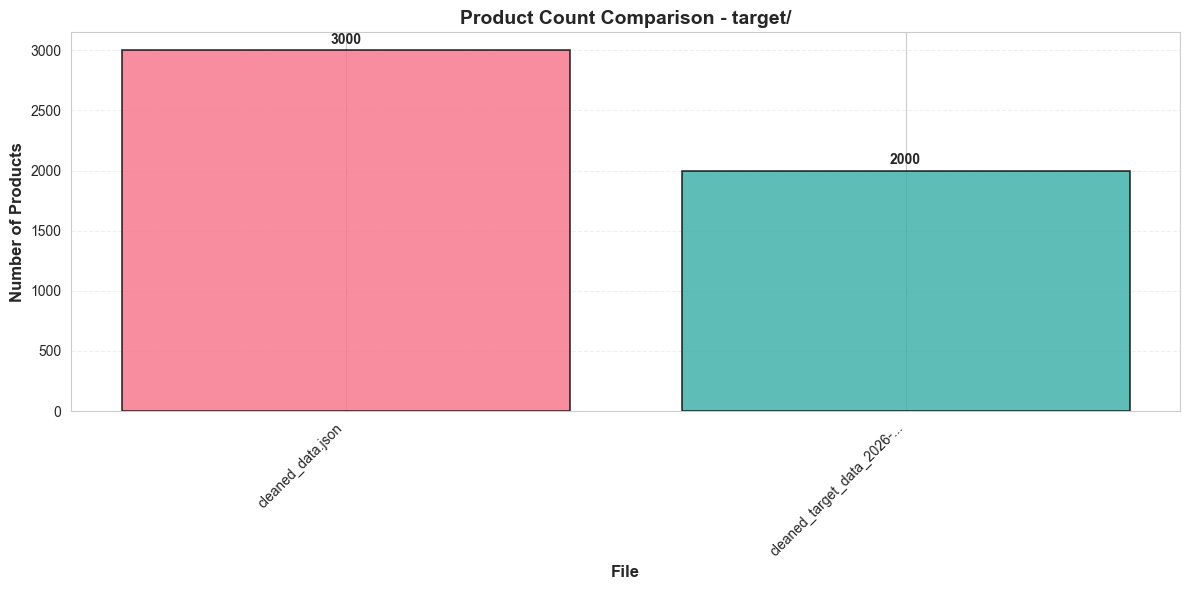

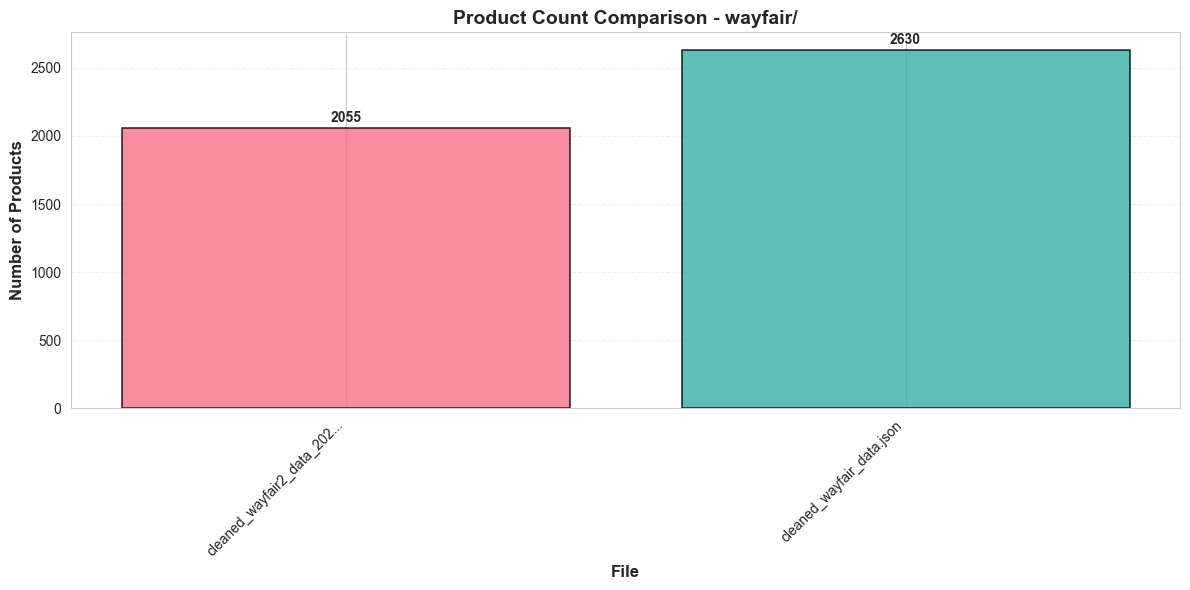

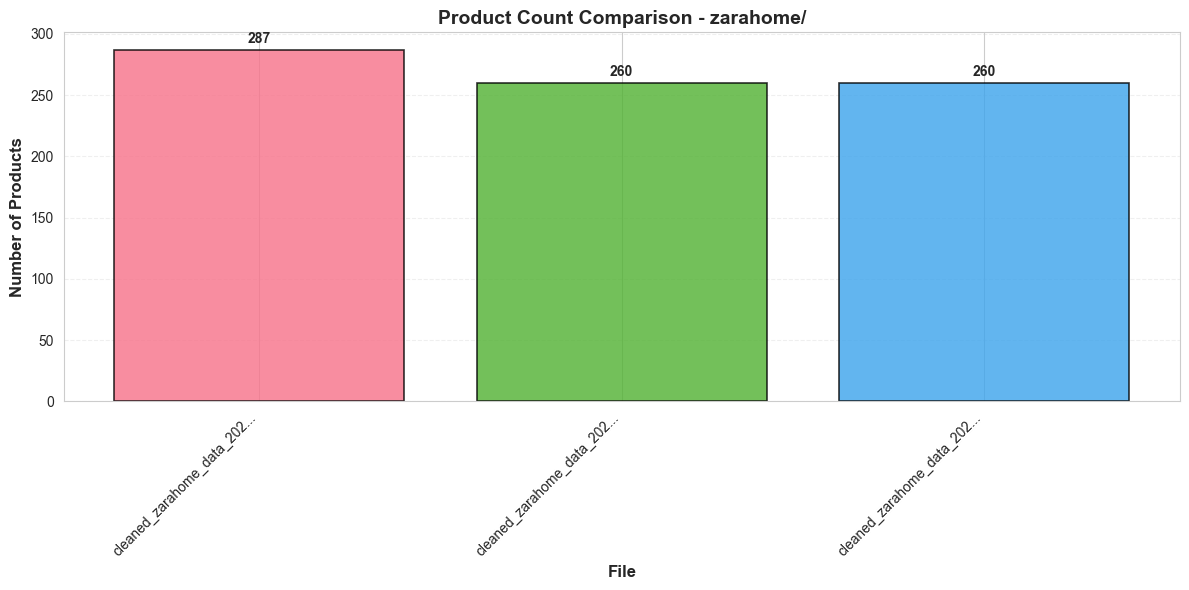

In [50]:
# Create bar charts comparing product counts across files in each folder
for folder in folders:
    if folder not in extracted_data or not extracted_data[folder]:
        continue
    
    files = list(extracted_data[folder].keys())
    counts = [len(extracted_data[folder][f]) for f in files]
    
    # Create figure with better sizing
    plt.figure(figsize=(12, 6))
    
    # Create bar chart
    bars = plt.bar(range(len(files)), counts, color=sns.color_palette("husl", len(files)), 
                    edgecolor='black', linewidth=1.2, alpha=0.8)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, counts)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                str(count), ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Customize plot
    plt.xlabel('File', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Products', fontsize=12, fontweight='bold')
    plt.title(f'Product Count Comparison - {folder}/', fontsize=14, fontweight='bold')
    plt.xticks(range(len(files)), [f[:25] + '...' if len(f) > 25 else f for f in files], 
               rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

## 10. Duplicate Distribution Visualization

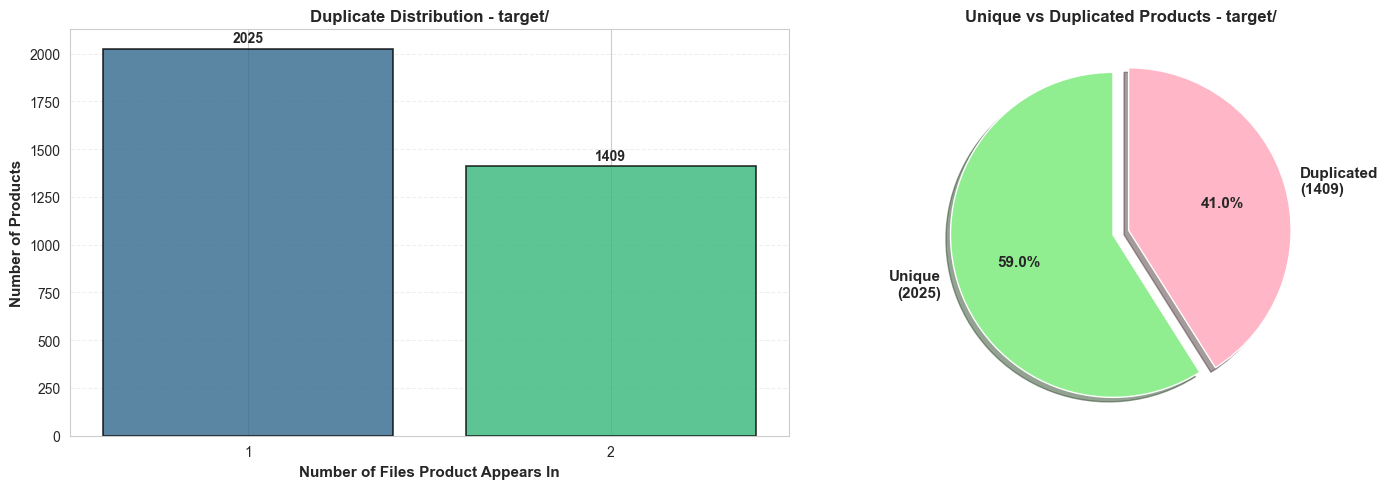

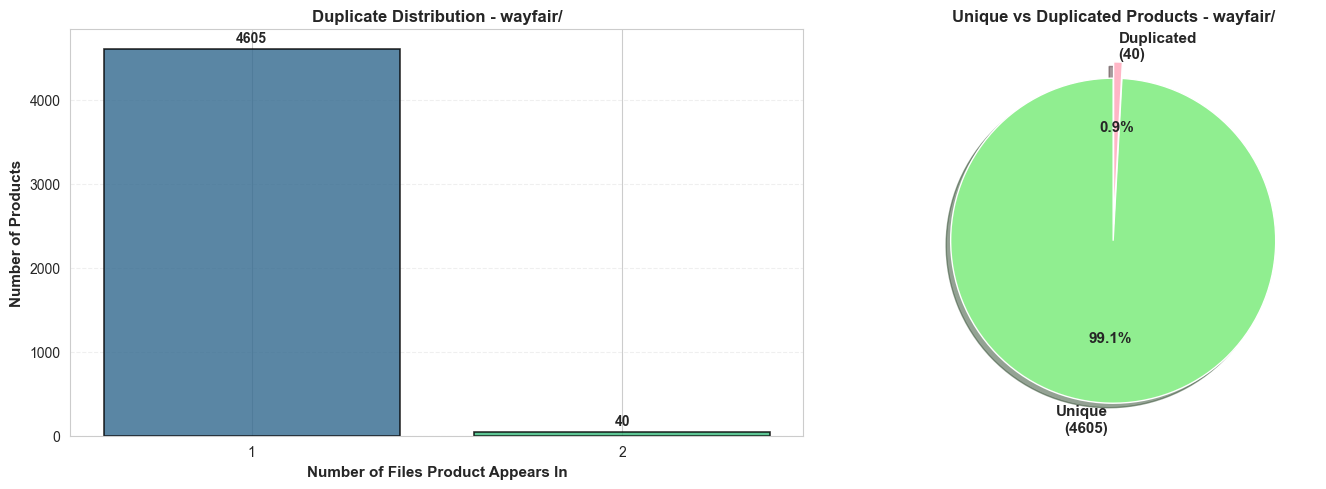

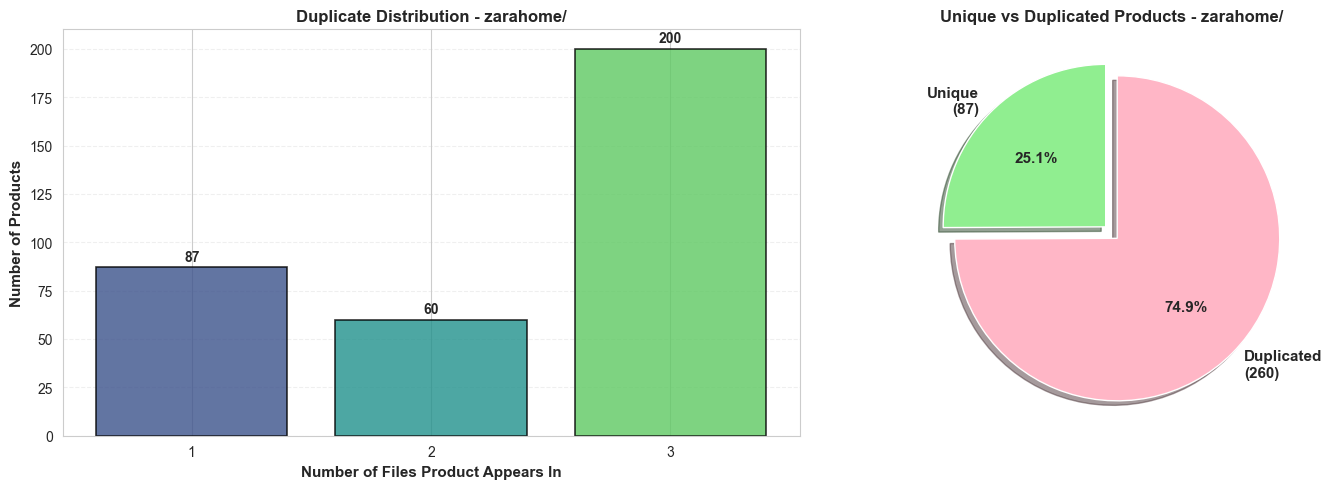

In [51]:
# Visualize how many products appear in multiple files
for folder in folders:
    if folder not in extracted_data or not extracted_data[folder]:
        continue
    
    files = list(extracted_data[folder].keys())
    if len(files) < 2:
        continue
    
    # Count how many files each URL appears in
    url_counts = defaultdict(int)
    for filename, products in extracted_data[folder].items():
        urls = set(p.get('url', '') for p in products if p.get('url', ''))
        for url in urls:
            url_counts[url] += 1
    
    # Group by frequency
    frequency_dist = defaultdict(int)
    for count in url_counts.values():
        frequency_dist[count] += 1
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Bar chart of frequency distribution
    freqs = sorted(frequency_dist.keys())
    counts = [frequency_dist[f] for f in freqs]
    colors = sns.color_palette("viridis", len(freqs))
    
    bars = ax1.bar(freqs, counts, color=colors, edgecolor='black', linewidth=1.2, alpha=0.8)
    for bar, count in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                str(count), ha='center', va='bottom', fontweight='bold')
    
    ax1.set_xlabel('Number of Files Product Appears In', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Number of Products', fontsize=11, fontweight='bold')
    ax1.set_title(f'Duplicate Distribution - {folder}/', fontsize=12, fontweight='bold')
    ax1.set_xticks(freqs)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Pie chart showing unique vs duplicated
    unique_count = frequency_dist.get(1, 0)
    duplicate_count = sum(count for freq, count in frequency_dist.items() if freq > 1)
    
    if unique_count + duplicate_count > 0:
        sizes = [unique_count, duplicate_count]
        labels = [f'Unique\n({unique_count})', f'Duplicated\n({duplicate_count})']
        colors_pie = ['#90EE90', '#FFB6C6']
        explode = (0.05, 0.05)
        
        wedges, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels, 
                                             colors=colors_pie, autopct='%1.1f%%',
                                             shadow=True, startangle=90,
                                             textprops={'fontsize': 11, 'fontweight': 'bold'})
        ax2.set_title(f'Unique vs Duplicated Products - {folder}/', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 10.5. Duplicate Counts: URLs vs Names Comparison


DUPLICATE PRODUCT SUMMARY - ALL FOLDERS

📁 TARGET/
   🔗 Duplicated Product URLs:  1525
   📝 Duplicated Product Names: 1497

📁 WAYFAIR/
   🔗 Duplicated Product URLs:  40
   📝 Duplicated Product Names: 270

📁 ZARAHOME/
   🔗 Duplicated Product URLs:  260
   📝 Duplicated Product Names: 243


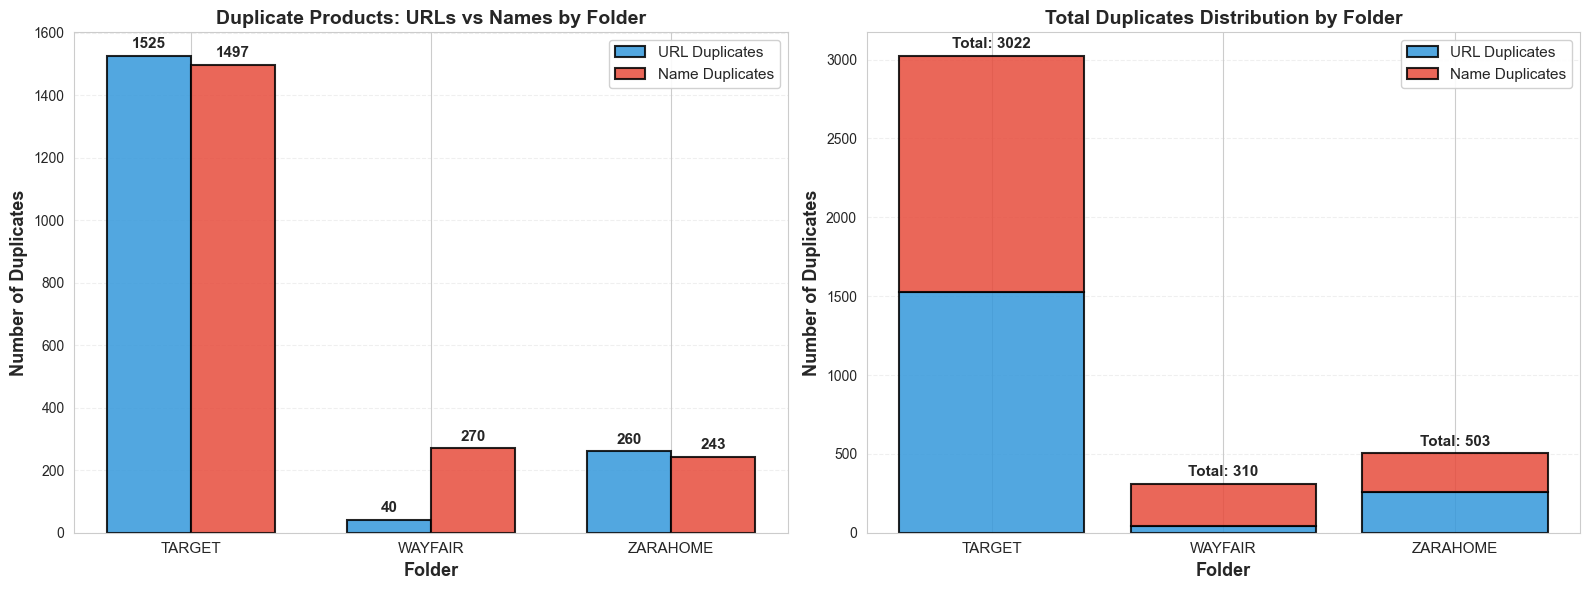


SUMMARY TABLE
          URL Duplicates  Name Duplicates  Total Duplicates
Folder                                                     
target              1525             1497              3022
wayfair               40              270               310
zarahome             260              243               503


In [52]:
# Display the number of duplicated product URLs and Names for all folders
duplicate_summary = {}

print("\n" + "="*70)
print("DUPLICATE PRODUCT SUMMARY - ALL FOLDERS")
print("="*70)

for folder in folders:
    if folder not in extracted_data or not extracted_data[folder]:
        continue
    
    # Find duplicates by URL
    url_duplicates = find_duplicates_by_field(folder, 'url')
    url_dup_count = len(url_duplicates)
    
    # Find duplicates by Name
    name_duplicates = find_duplicates_by_field(folder, 'name')
    name_dup_count = len(name_duplicates)
    
    duplicate_summary[folder] = {
        'URL Duplicates': url_dup_count,
        'Name Duplicates': name_dup_count
    }
    
    print(f"\n📁 {folder.upper()}/")
    print(f"   🔗 Duplicated Product URLs:  {url_dup_count}")
    print(f"   📝 Duplicated Product Names: {name_dup_count}")

# Create visualization comparing URL vs Name duplicates across folders
if duplicate_summary:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Grouped bar chart
    folder_names = list(duplicate_summary.keys())
    url_dups = [duplicate_summary[f]['URL Duplicates'] for f in folder_names]
    name_dups = [duplicate_summary[f]['Name Duplicates'] for f in folder_names]
    
    x = range(len(folder_names))
    width = 0.35
    
    bars1 = ax1.bar([xi - width/2 for xi in x], url_dups, width, label='URL Duplicates',
                    color='#3498db', edgecolor='black', linewidth=1.5, alpha=0.85)
    bars2 = ax1.bar([xi + width/2 for xi in x], name_dups, width, label='Name Duplicates',
                    color='#e74c3c', edgecolor='black', linewidth=1.5, alpha=0.85)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax1.text(bar.get_x() + bar.get_width()/2, height + max(url_dups + name_dups)*0.01,
                        f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax1.set_xlabel('Folder', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Number of Duplicates', fontsize=13, fontweight='bold')
    ax1.set_title('Duplicate Products: URLs vs Names by Folder', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f.upper() for f in folder_names], fontsize=11)
    ax1.legend(loc='upper right', fontsize=11, framealpha=0.9)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Stacked bar chart showing total duplicates
    total_dups = [url_dups[i] + name_dups[i] for i in range(len(folder_names))]
    
    bars_url = ax2.bar(x, url_dups, label='URL Duplicates',
                       color='#3498db', edgecolor='black', linewidth=1.5, alpha=0.85)
    bars_name = ax2.bar(x, name_dups, bottom=url_dups, label='Name Duplicates',
                        color='#e74c3c', edgecolor='black', linewidth=1.5, alpha=0.85)
    
    # Add total labels on top
    for i, (bar_url, bar_name, total) in enumerate(zip(bars_url, bars_name, total_dups)):
        if total > 0:
            ax2.text(bar_url.get_x() + bar_url.get_width()/2, total + max(total_dups)*0.01,
                    f'Total: {total}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax2.set_xlabel('Folder', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Number of Duplicates', fontsize=13, fontweight='bold')
    ax2.set_title('Total Duplicates Distribution by Folder', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f.upper() for f in folder_names], fontsize=11)
    ax2.legend(loc='upper right', fontsize=11, framealpha=0.9)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Create a summary table
    print("\n" + "="*70)
    print("SUMMARY TABLE")
    print("="*70)
    df_summary = pd.DataFrame(duplicate_summary).T
    df_summary['Total Duplicates'] = df_summary['URL Duplicates'] + df_summary['Name Duplicates']
    df_summary.index.name = 'Folder'
    print(df_summary.to_string())
    print("="*70)

## 10.6. Duplicate Price Consistency Analysis


DUPLICATE PRICE CONSISTENCY CHECK - ALL FOLDERS

📁 TARGET/

📊 Total Duplicate URLs: 1525
   ✅ Same price across files: 1045
   ⚠️  Different prices: 480
   ❌ Missing price data: 0

⚠️  Price Discrepancies Found (showing up to 5):

   1. Product: Costway Freestanding Wooden Coat Tree 360° Rotary 
      URL: https://www.target.com/p/costway-freestanding-wooden-coat-tree-360-rotary-coat-r...
      Prices: $69.99, $69.99, $74.99
      Files: cleaned_data.json, cleaned_data.json, cleaned_target_data_2026-01-12T18-26-36.json

   2. Product: Cary Transitional 6 Drawer Solid Wood Contoured Ha
      URL: https://www.target.com/p/cary-transitional-6-drawer-solid-wood-contoured-handle-...
      Prices: $84.99, $74.99
      Files: cleaned_data.json, cleaned_target_data_2026-01-12T18-26-36.json

   3. Product: Dyonery 5-Seat Sectional Sleeper Sofa Bed with Pul
      URL: https://www.target.com/p/dyonery-5-seat-sectional-sleeper-sofa-bed-with-pull-out...
      Prices: $619.99, $649.99
      Files: 

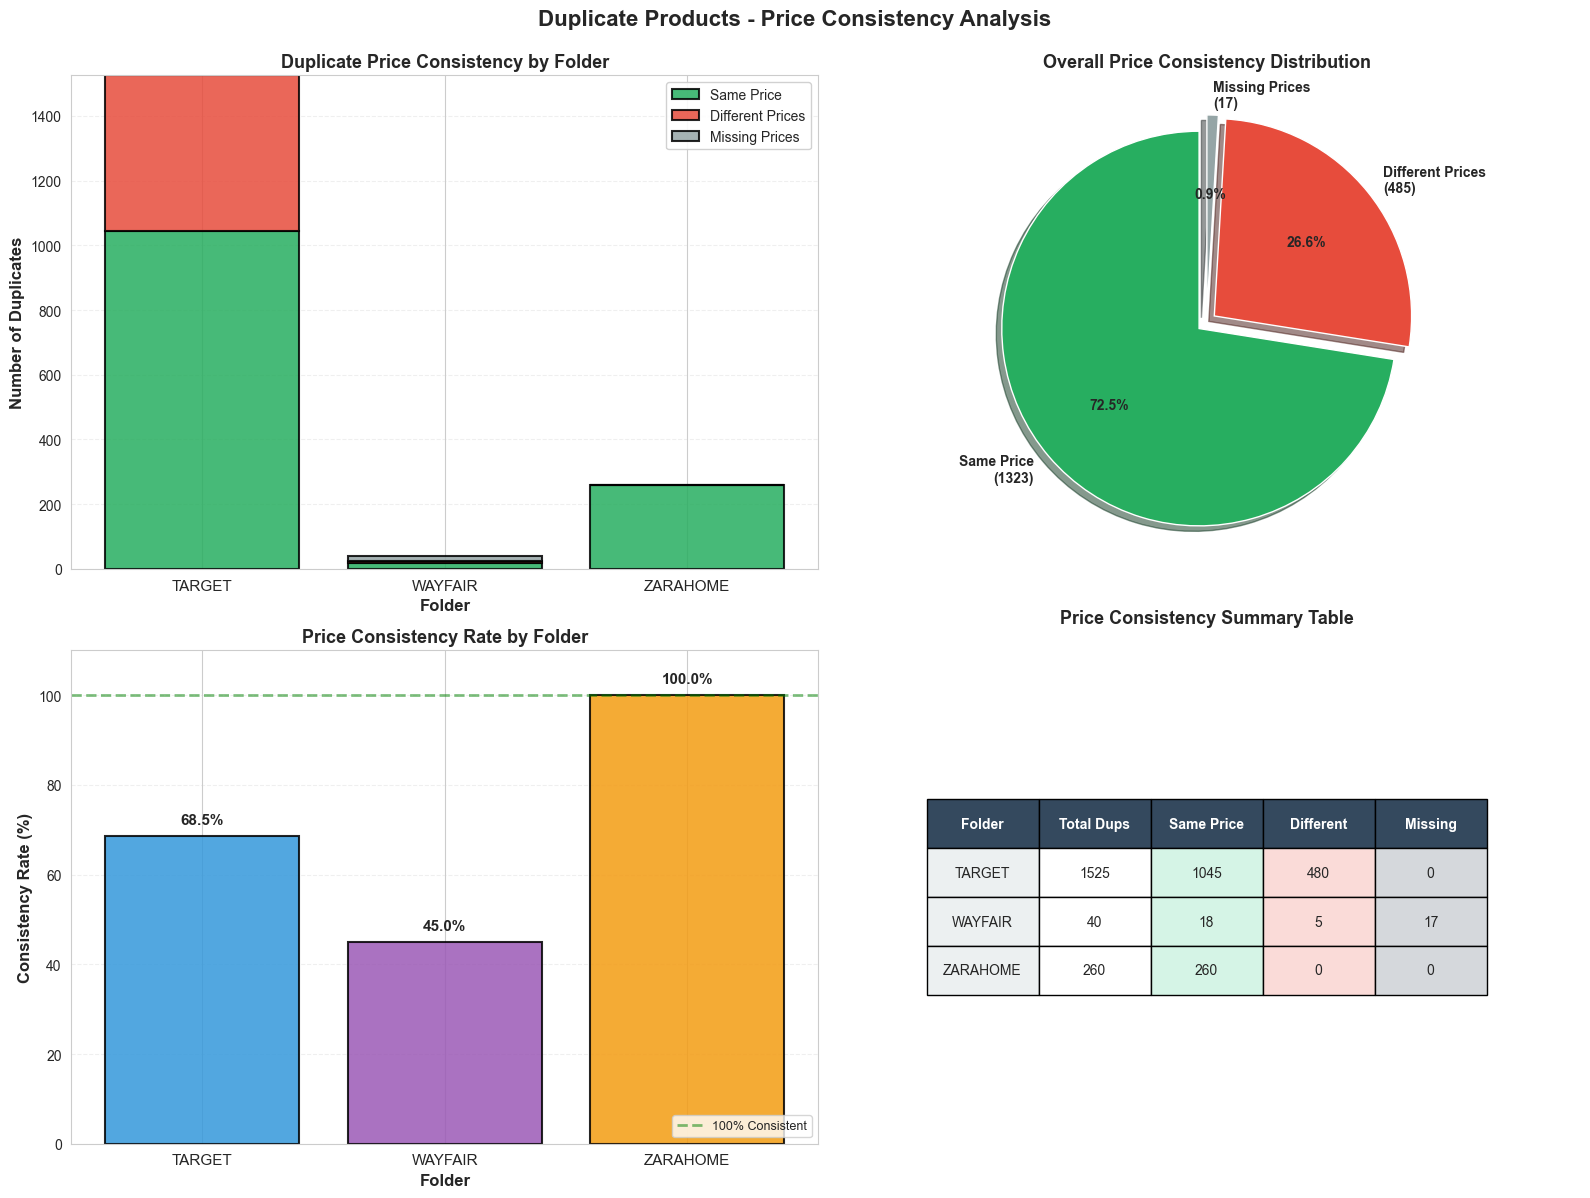


OVERALL PRICE CONSISTENCY SUMMARY
          Total Duplicates  Same Price  Different Prices  Missing Prices
Folder                                                                  
target                1525        1045               480               0
wayfair                 40          18                 5              17
zarahome               260         260                 0               0


In [53]:
# Check if duplicate products have the same prices across files
import re

def extract_numeric_price(price_value):
    """Extract numeric price from various formats"""
    if not price_value:
        return None
    
    price_str = str(price_value)
    # Remove currency symbols and extract numbers
    numbers = re.findall(r'\d+\.?\d*', price_str)
    if numbers:
        try:
            return float(numbers[0])
        except:
            return None
    return None

print("\n" + "="*70)
print("DUPLICATE PRICE CONSISTENCY CHECK - ALL FOLDERS")
print("="*70)

price_consistency_summary = {}

for folder in folders:
    if folder not in extracted_data or not extracted_data[folder]:
        continue
    
    print(f"\n{'='*70}")
    print(f"📁 {folder.upper()}/")
    print(f"{'='*70}")
    
    # Get URL duplicates
    url_duplicates = find_duplicates_by_field(folder, 'url')
    
    same_price_count = 0
    different_price_count = 0
    missing_price_count = 0
    
    price_discrepancies = []
    
    for url, occurrences in url_duplicates.items():
        # Extract prices from all occurrences
        prices = []
        files_with_prices = []
        
        for occ in occurrences:
            price = extract_numeric_price(occ['product'].get('price', ''))
            if price is not None:
                prices.append(price)
                files_with_prices.append(occ['file'])
        
        # Check price consistency
        if len(prices) == 0:
            missing_price_count += 1
        elif len(prices) == 1:
            # Only one file has a price, can't compare
            missing_price_count += 1
        else:
            # Check if all prices are the same
            unique_prices = set(prices)
            if len(unique_prices) == 1:
                same_price_count += 1
            else:
                different_price_count += 1
                # Store discrepancy details
                price_discrepancies.append({
                    'url': url[:80] + '...' if len(url) > 80 else url,
                    'prices': prices,
                    'files': files_with_prices,
                    'product_name': occurrences[0]['product'].get('name', 'N/A')[:50]
                })
    
    total_url_duplicates = len(url_duplicates)
    
    price_consistency_summary[folder] = {
        'Total Duplicates': total_url_duplicates,
        'Same Price': same_price_count,
        'Different Prices': different_price_count,
        'Missing Prices': missing_price_count
    }
    
    print(f"\n📊 Total Duplicate URLs: {total_url_duplicates}")
    print(f"   ✅ Same price across files: {same_price_count}")
    print(f"   ⚠️  Different prices: {different_price_count}")
    print(f"   ❌ Missing price data: {missing_price_count}")
    
    if different_price_count > 0:
        print(f"\n⚠️  Price Discrepancies Found (showing up to 5):")
        for i, disc in enumerate(price_discrepancies[:5]):
            print(f"\n   {i+1}. Product: {disc['product_name']}")
            print(f"      URL: {disc['url']}")
            print(f"      Prices: {', '.join(f'${p:.2f}' for p in disc['prices'])}")
            print(f"      Files: {', '.join(disc['files'])}")

# Create visualization
if price_consistency_summary:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    folder_names = list(price_consistency_summary.keys())
    
    # 1. Stacked bar chart of consistency status
    ax1 = axes[0, 0]
    same_prices = [price_consistency_summary[f]['Same Price'] for f in folder_names]
    diff_prices = [price_consistency_summary[f]['Different Prices'] for f in folder_names]
    missing_prices = [price_consistency_summary[f]['Missing Prices'] for f in folder_names]
    
    x = range(len(folder_names))
    bars1 = ax1.bar(x, same_prices, label='Same Price', color='#27AE60', 
                    edgecolor='black', linewidth=1.5, alpha=0.85)
    bars2 = ax1.bar(x, diff_prices, bottom=same_prices, label='Different Prices', 
                    color='#E74C3C', edgecolor='black', linewidth=1.5, alpha=0.85)
    bars3 = ax1.bar(x, missing_prices, bottom=[same_prices[i] + diff_prices[i] for i in range(len(x))],
                    label='Missing Prices', color='#95A5A6', edgecolor='black', linewidth=1.5, alpha=0.85)
    
    ax1.set_xlabel('Folder', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Duplicates', fontsize=12, fontweight='bold')
    ax1.set_title('Duplicate Price Consistency by Folder', fontsize=13, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f.upper() for f in folder_names], fontsize=11)
    ax1.legend(loc='upper right', fontsize=10, framealpha=0.9)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # 2. Pie chart for overall consistency
    ax2 = axes[0, 1]
    total_same = sum(same_prices)
    total_diff = sum(diff_prices)
    total_missing = sum(missing_prices)
    
    if total_same + total_diff + total_missing > 0:
        sizes = [total_same, total_diff, total_missing]
        labels = [f'Same Price\n({total_same})', f'Different Prices\n({total_diff})', 
                  f'Missing Prices\n({total_missing})']
        colors_pie = ['#27AE60', '#E74C3C', '#95A5A6']
        explode = (0.05, 0.05, 0.05)
        
        wedges, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels, 
                                             colors=colors_pie, autopct='%1.1f%%',
                                             shadow=True, startangle=90,
                                             textprops={'fontsize': 10, 'fontweight': 'bold'})
        ax2.set_title('Overall Price Consistency Distribution', fontsize=13, fontweight='bold')
    
    # 3. Percentage of price consistency
    ax3 = axes[1, 0]
    consistency_pct = []
    for f in folder_names:
        total = price_consistency_summary[f]['Total Duplicates']
        same = price_consistency_summary[f]['Same Price']
        if total > 0:
            consistency_pct.append((same / total) * 100)
        else:
            consistency_pct.append(0)
    
    bars = ax3.bar(x, consistency_pct, color=['#3498DB', '#9B59B6', '#F39C12'],
                   edgecolor='black', linewidth=1.5, alpha=0.85)
    
    for bar, val in zip(bars, consistency_pct):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax3.axhline(y=100, color='green', linestyle='--', alpha=0.5, linewidth=2, label='100% Consistent')
    ax3.set_xlabel('Folder', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Consistency Rate (%)', fontsize=12, fontweight='bold')
    ax3.set_title('Price Consistency Rate by Folder', fontsize=13, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels([f.upper() for f in folder_names], fontsize=11)
    ax3.set_ylim(0, 110)
    ax3.legend(loc='lower right', fontsize=9)
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    
    # 4. Summary table visualization
    ax4 = axes[1, 1]
    ax4.axis('tight')
    ax4.axis('off')
    
    # Create table data
    table_data = []
    table_data.append(['Folder', 'Total Dups', 'Same Price', 'Different', 'Missing'])
    for f in folder_names:
        table_data.append([
            f.upper(),
            str(price_consistency_summary[f]['Total Duplicates']),
            str(price_consistency_summary[f]['Same Price']),
            str(price_consistency_summary[f]['Different Prices']),
            str(price_consistency_summary[f]['Missing Prices'])
        ])
    
    table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.15, 0.15, 0.15, 0.15, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.5)
    
    # Style header row
    for i in range(5):
        table[(0, i)].set_facecolor('#34495E')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color code the data cells
    for i in range(1, len(table_data)):
        table[(i, 0)].set_facecolor('#ECF0F1')
        table[(i, 2)].set_facecolor('#D5F4E6')  # Same price - green
        table[(i, 3)].set_facecolor('#FADBD8')  # Different - red
        table[(i, 4)].set_facecolor('#D5D8DC')  # Missing - gray
    
    ax4.set_title('Price Consistency Summary Table', fontsize=13, fontweight='bold', pad=20)
    
    plt.suptitle('Duplicate Products - Price Consistency Analysis', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "="*70)
    print("OVERALL PRICE CONSISTENCY SUMMARY")
    print("="*70)
    df_price_summary = pd.DataFrame(price_consistency_summary).T
    df_price_summary.index.name = 'Folder'
    print(df_price_summary.to_string())
    print("="*70)

## 11. Unique vs Shared Products Visualization

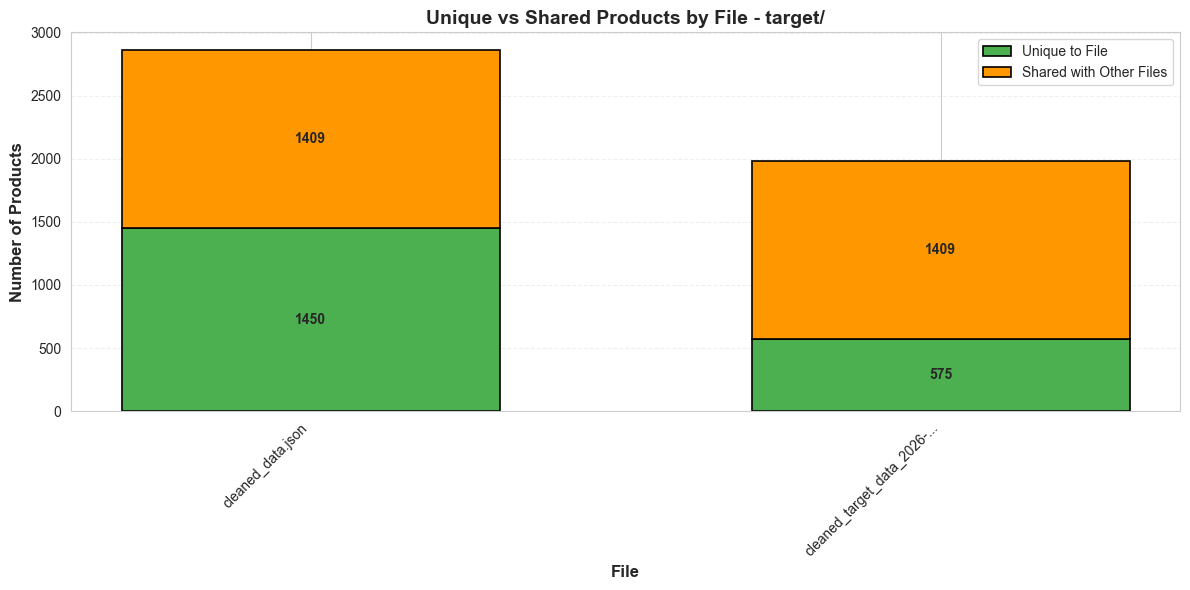

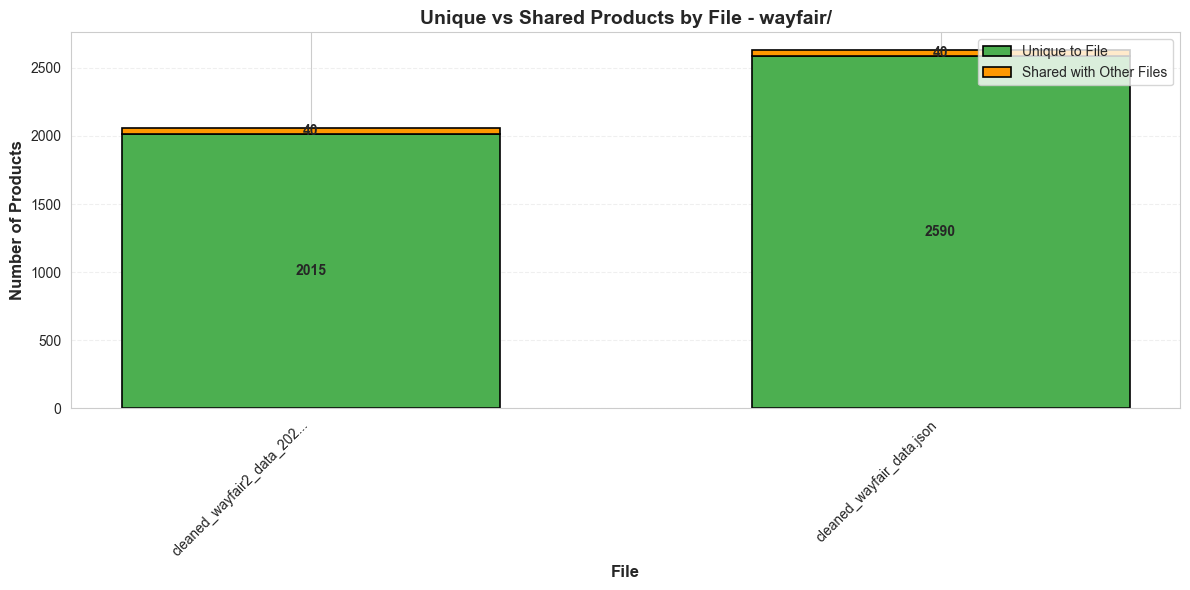

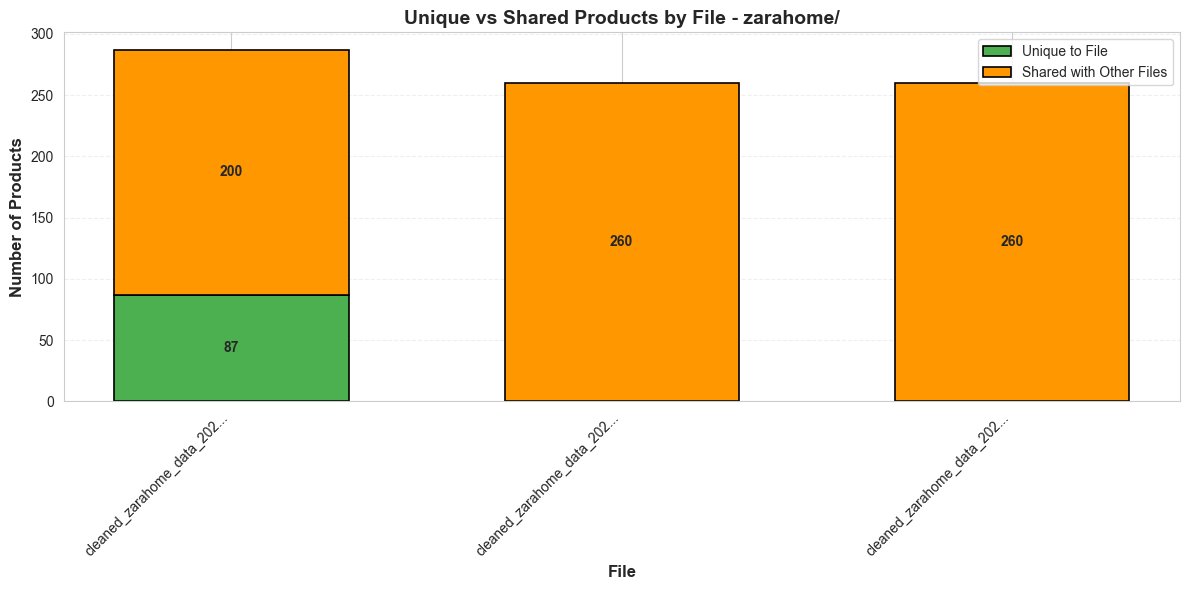

In [54]:
# Stacked bar chart showing unique vs shared products per file
for folder in folders:
    if folder not in extracted_data or not extracted_data[folder]:
        continue
    
    files = list(extracted_data[folder].keys())
    if len(files) < 2:
        continue
    
    # Calculate unique and shared counts for each file
    unique_counts = []
    shared_counts = []
    
    for filename in files:
        products_set = set(p.get('url', '') for p in extracted_data[folder][filename] if p.get('url', ''))
        
        # Get all products from other files
        other_products = set()
        for other_file in files:
            if other_file != filename:
                other_set = set(p.get('url', '') for p in extracted_data[folder][other_file] if p.get('url', ''))
                other_products.update(other_set)
        
        unique = len(products_set - other_products)
        shared = len(products_set & other_products)
        
        unique_counts.append(unique)
        shared_counts.append(shared)
    
    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = range(len(files))
    width = 0.6
    
    bars1 = ax.bar(x, unique_counts, width, label='Unique to File', 
                   color='#4CAF50', edgecolor='black', linewidth=1.2)
    bars2 = ax.bar(x, shared_counts, width, bottom=unique_counts, label='Shared with Other Files',
                   color='#FF9800', edgecolor='black', linewidth=1.2)
    
    # Add labels on bars
    for i, (b1, b2, unique, shared) in enumerate(zip(bars1, bars2, unique_counts, shared_counts)):
        # Label for unique
        if unique > 0:
            ax.text(b1.get_x() + b1.get_width()/2, unique/2, str(unique),
                   ha='center', va='center', fontweight='bold', fontsize=10)
        # Label for shared
        if shared > 0:
            ax.text(b2.get_x() + b2.get_width()/2, unique + shared/2, str(shared),
                   ha='center', va='center', fontweight='bold', fontsize=10)
    
    ax.set_xlabel('File', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Products', fontsize=12, fontweight='bold')
    ax.set_title(f'Unique vs Shared Products by File - {folder}/', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f[:25] + '...' if len(f) > 25 else f for f in files], 
                       rotation=45, ha='right')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

## 12. Field Completeness Analysis

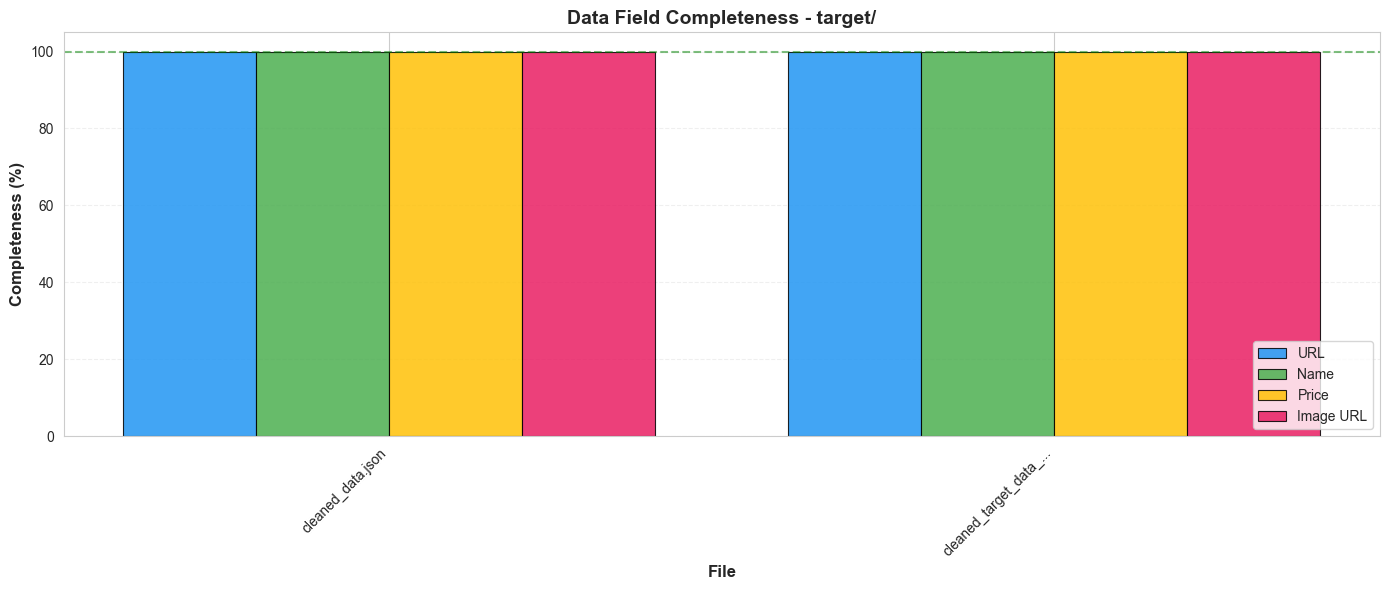

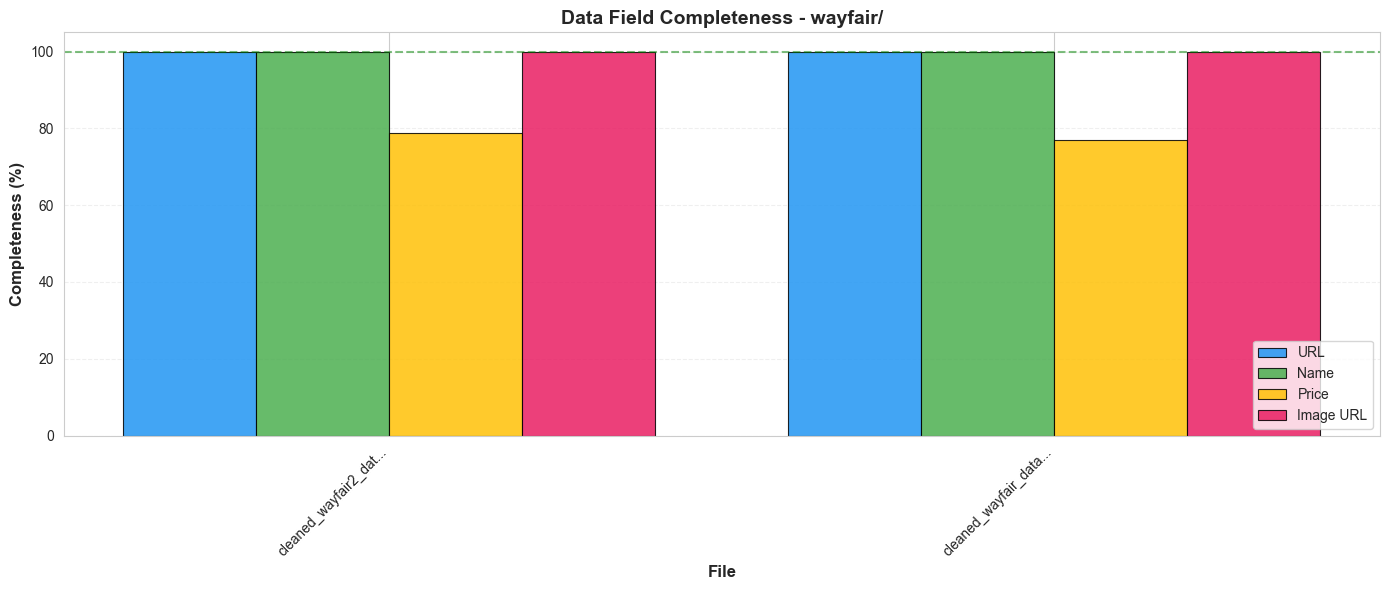

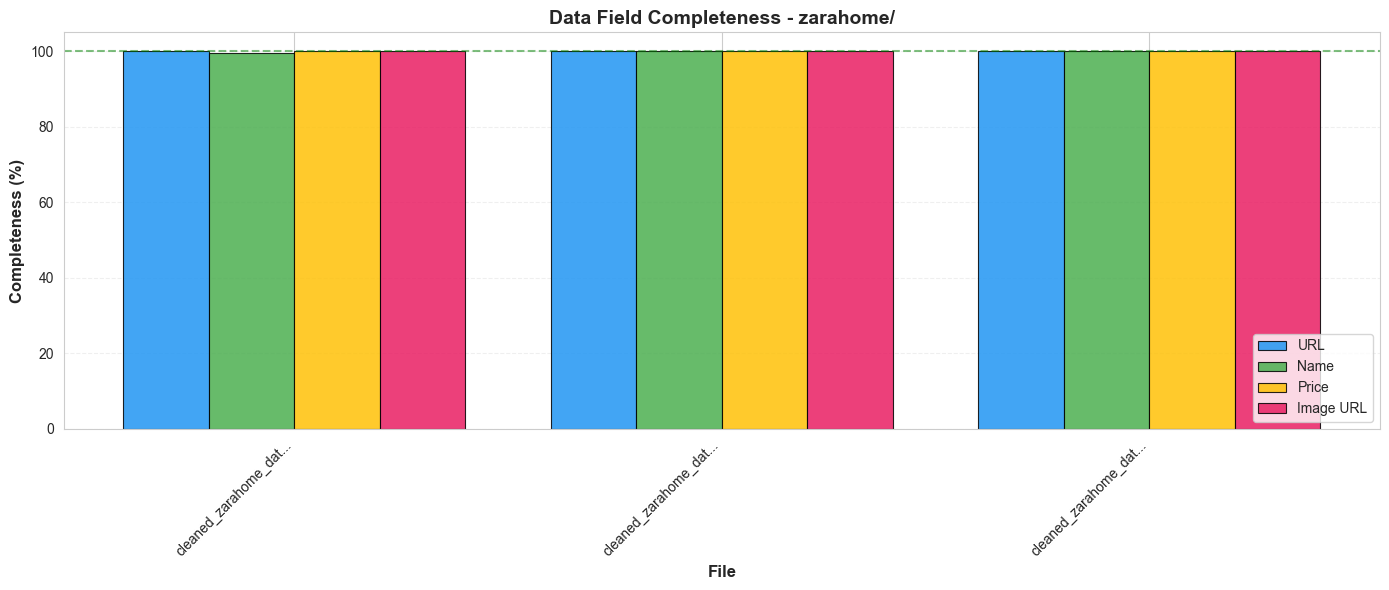

In [55]:
# Analyze how complete the data fields are (URL, Name, Price, Image URL)
for folder in folders:
    if folder not in extracted_data or not extracted_data[folder]:
        continue
    
    files = list(extracted_data[folder].keys())
    
    completeness_data = []
    
    for filename, products in extracted_data[folder].items():
        total = len(products)
        if total == 0:
            continue
            
        url_count = sum(1 for p in products if p.get('url', ''))
        name_count = sum(1 for p in products if p.get('name', ''))
        price_count = sum(1 for p in products if p.get('price', ''))
        image_count = sum(1 for p in products if p.get('image_url', ''))
        
        completeness_data.append({
            'File': filename,
            'URL': (url_count / total) * 100,
            'Name': (name_count / total) * 100,
            'Price': (price_count / total) * 100,
            'Image URL': (image_count / total) * 100
        })
    
    if not completeness_data:
        continue
    
    # Create grouped bar chart
    df_comp = pd.DataFrame(completeness_data)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    x = range(len(completeness_data))
    width = 0.2
    
    fields = ['URL', 'Name', 'Price', 'Image URL']
    colors_comp = ['#2196F3', '#4CAF50', '#FFC107', '#E91E63']
    
    for i, (field, color) in enumerate(zip(fields, colors_comp)):
        values = df_comp[field].values
        bars = ax.bar([xi + i*width for xi in x], values, width, label=field, 
                      color=color, edgecolor='black', linewidth=0.8, alpha=0.85)
    
    ax.set_xlabel('File', fontsize=12, fontweight='bold')
    ax.set_ylabel('Completeness (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'Data Field Completeness - {folder}/', fontsize=14, fontweight='bold')
    ax.set_xticks([xi + width*1.5 for xi in x])
    ax.set_xticklabels([f[:20] + '...' if len(f) > 20 else f for f in df_comp['File']], 
                       rotation=45, ha='right')
    ax.set_ylim(0, 105)
    ax.axhline(y=100, color='green', linestyle='--', alpha=0.5, linewidth=1.5)
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

## 13. Price Distribution Analysis

C:\Users\njiem\AppData\Local\Temp\ipykernel_23588\2577071722.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(data_for_box, labels=labels_for_box, patch_artist=True,


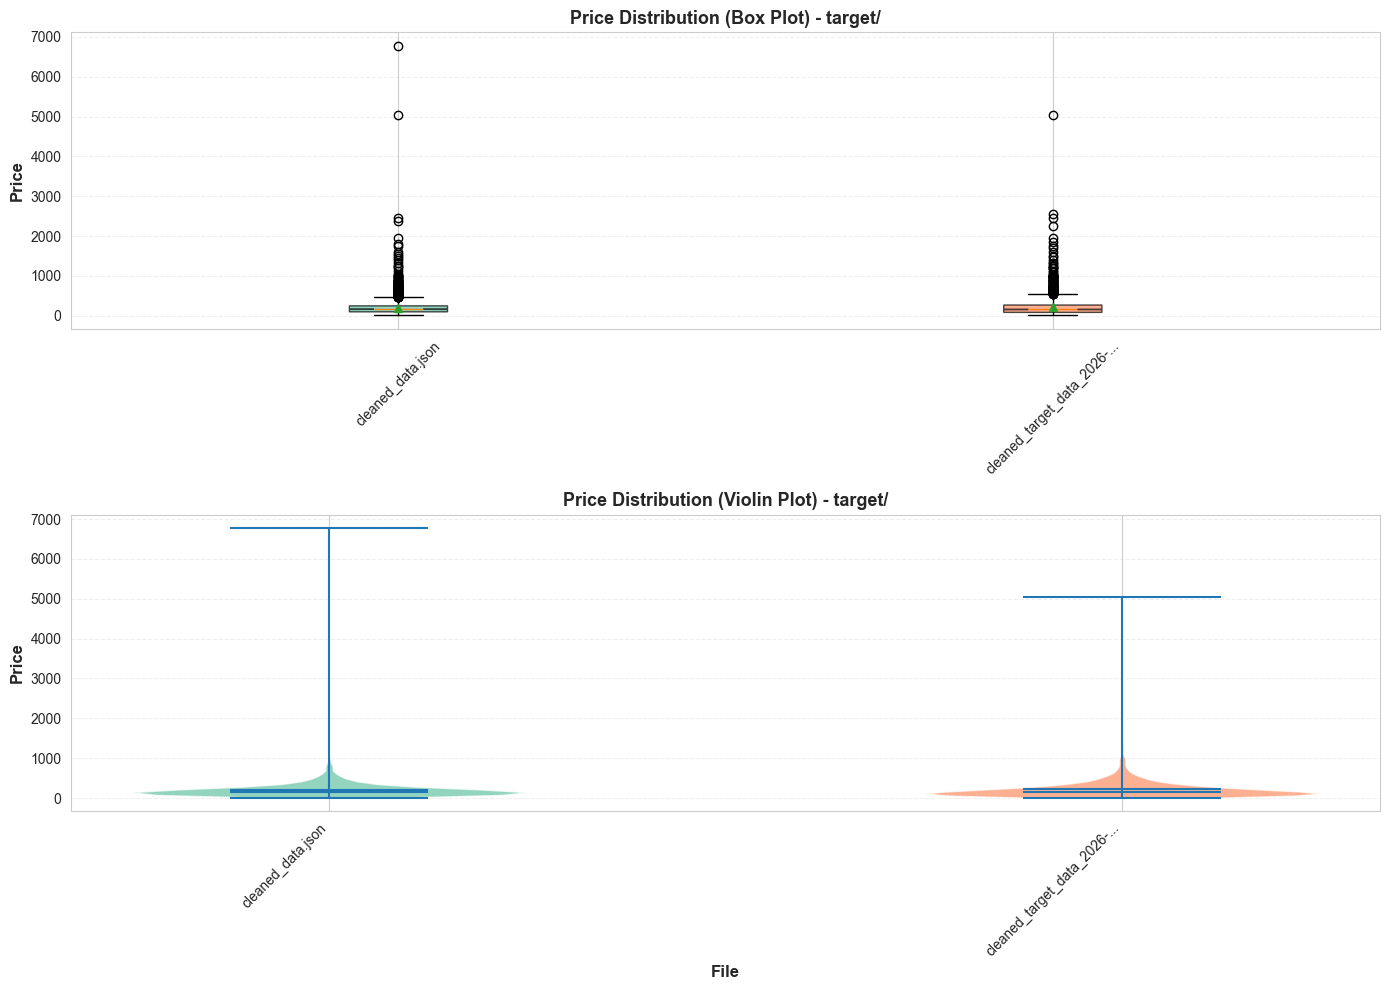


Price Statistics - target/

cleaned_data.json:
  Count: 3000
  Min: $10.00
  Max: $6775.99
  Mean: $206.97
  Median: $163.41

cleaned_target_data_2026-01-12T18-26-36.json:
  Count: 2000
  Min: $10.00
  Max: $5039.20
  Mean: $218.03
  Median: $159.20


C:\Users\njiem\AppData\Local\Temp\ipykernel_23588\2577071722.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(data_for_box, labels=labels_for_box, patch_artist=True,


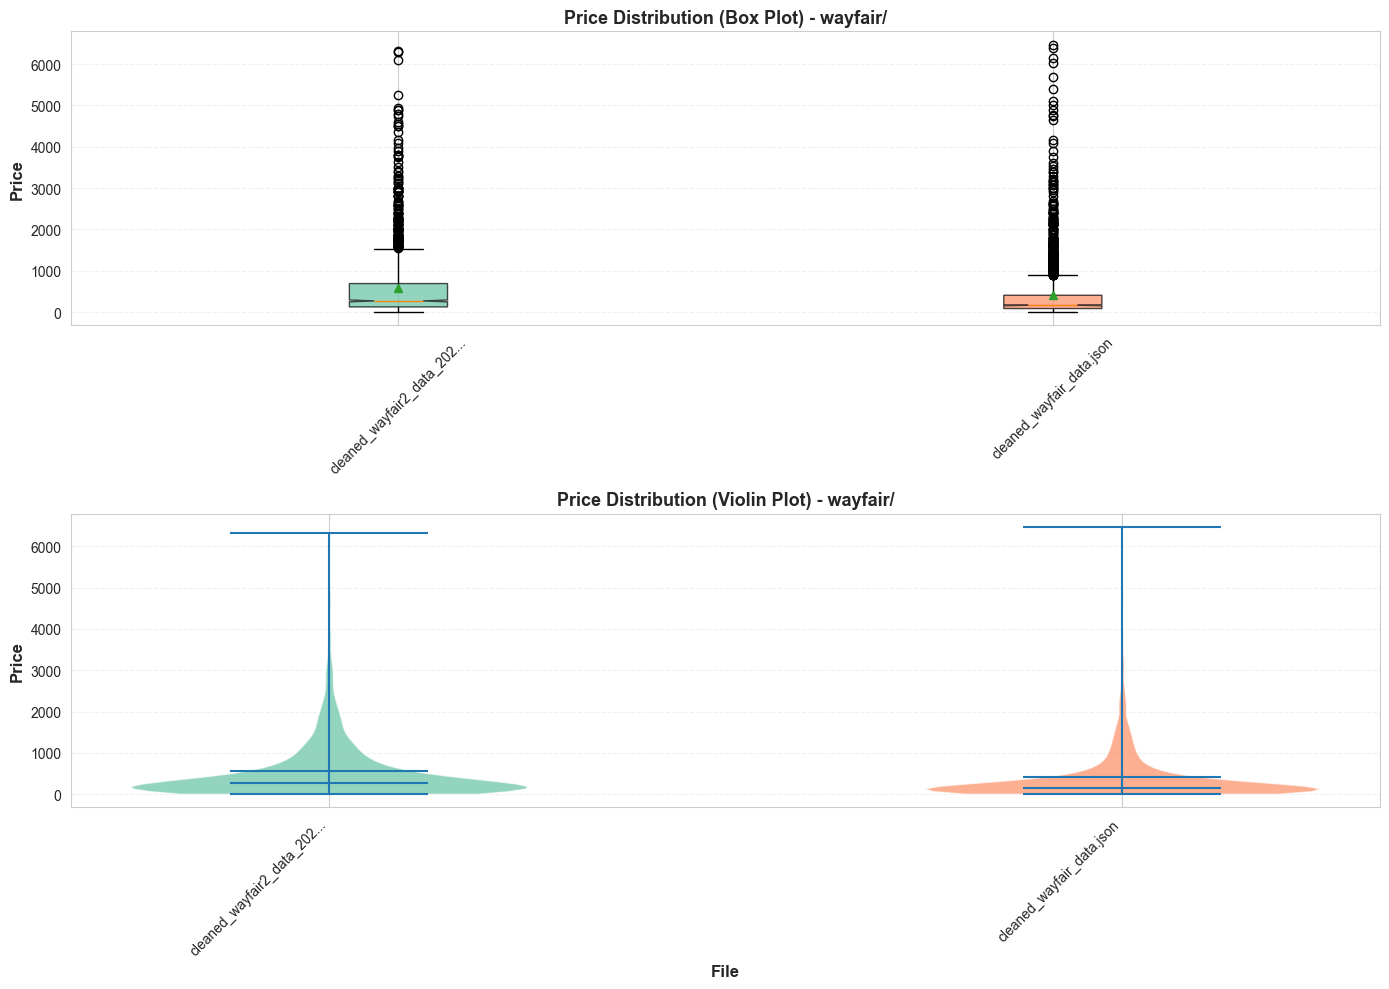


Price Statistics - wayfair/

cleaned_wayfair2_data_2026-01-10_22-44-01-180.json:
  Count: 1619
  Min: $10.50
  Max: $6319.00
  Mean: $571.67
  Median: $269.99

cleaned_wayfair_data.json:
  Count: 2023
  Min: $10.99
  Max: $6469.00
  Mean: $412.24
  Median: $163.99


C:\Users\njiem\AppData\Local\Temp\ipykernel_23588\2577071722.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(data_for_box, labels=labels_for_box, patch_artist=True,


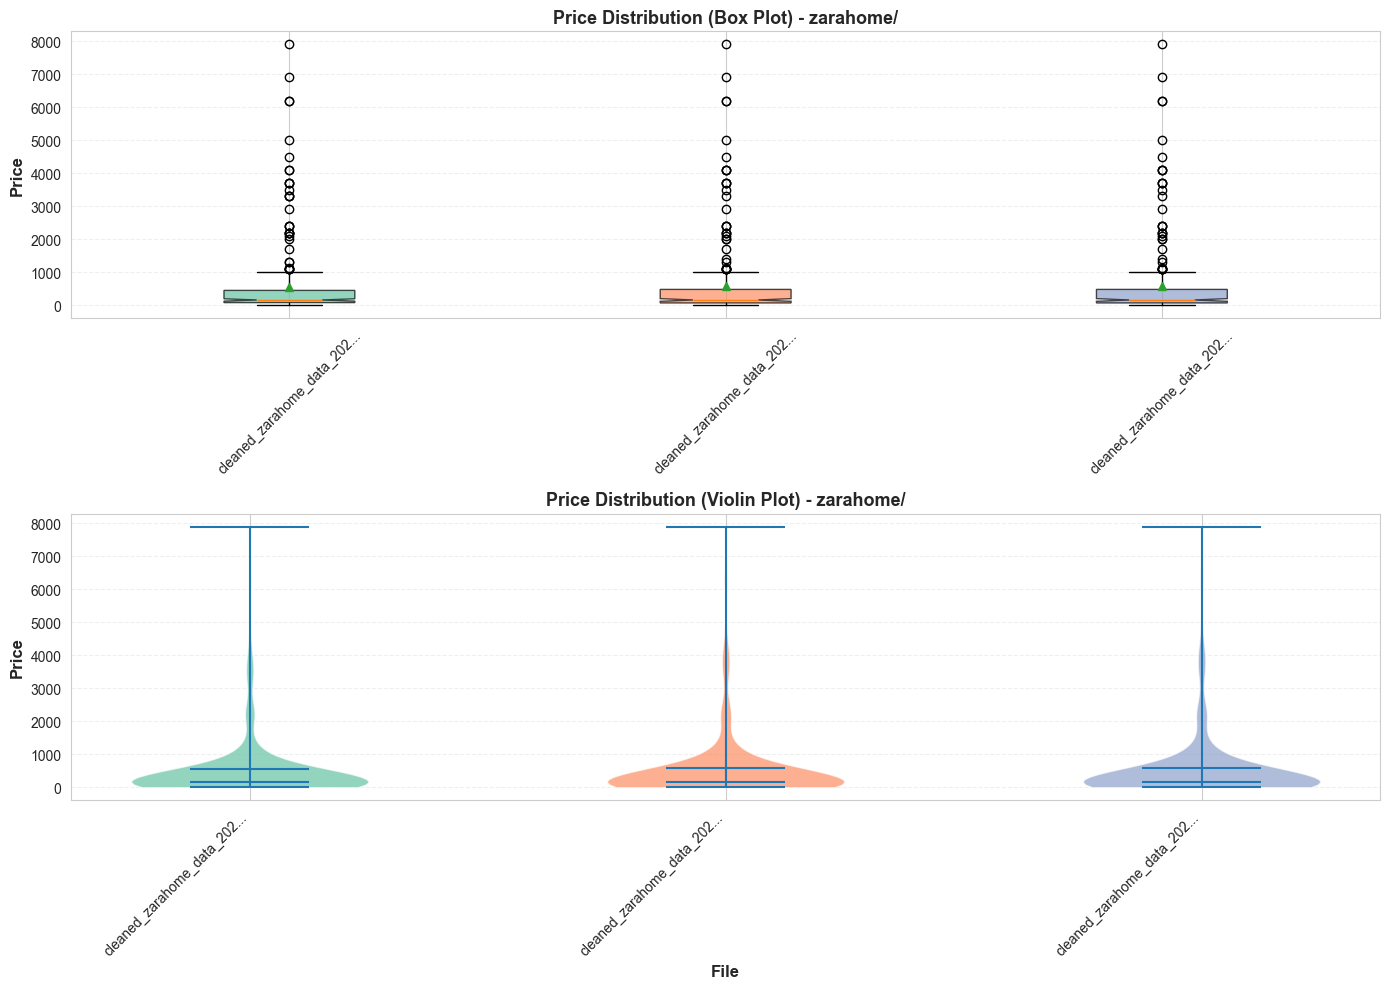


Price Statistics - zarahome/

cleaned_zarahome_data_2025-12-17_07-32-46-404.json:
  Count: 287
  Min: $5.99
  Max: $7900.00
  Mean: $552.74
  Median: $159.99

cleaned_zarahome_data_2026-01-01_11-54-37-460.json:
  Count: 260
  Min: $5.99
  Max: $7900.00
  Mean: $580.90
  Median: $159.99

cleaned_zarahome_data_2026-01-10_21-52-39-441.json:
  Count: 260
  Min: $5.99
  Max: $7900.00
  Mean: $580.90
  Median: $159.99


In [56]:
# Visualize price distributions across files in each folder
import re

def extract_numeric_price(price_value):
    """Extract numeric price from various formats"""
    if not price_value:
        return None
    
    price_str = str(price_value)
    # Remove currency symbols and extract numbers
    numbers = re.findall(r'\d+\.?\d*', price_str)
    if numbers:
        try:
            return float(numbers[0])
        except:
            return None
    return None

for folder in folders:
    if folder not in extracted_data or not extracted_data[folder]:
        continue
    
    files = list(extracted_data[folder].keys())
    
    # Collect prices for each file
    file_prices = {}
    for filename, products in extracted_data[folder].items():
        prices = []
        for p in products:
            price = extract_numeric_price(p.get('price', ''))
            if price is not None and price > 0:
                prices.append(price)
        if prices:
            file_prices[filename] = prices
    
    if not file_prices:
        print(f"No valid prices found in {folder}/")
        continue
    
    # Create visualizations
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Box plot
    ax1 = axes[0]
    data_for_box = [file_prices[f] for f in files if f in file_prices]
    labels_for_box = [f[:25] + '...' if len(f) > 25 else f for f in files if f in file_prices]
    
    bp = ax1.boxplot(data_for_box, labels=labels_for_box, patch_artist=True,
                     notch=True, showmeans=True)
    
    # Color the boxes
    colors_box = sns.color_palette("Set2", len(data_for_box))
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
    ax1.set_title(f'Price Distribution (Box Plot) - {folder}/', fontsize=13, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Violin plot
    ax2 = axes[1]
    parts = ax2.violinplot(data_for_box, positions=range(len(data_for_box)), 
                           showmeans=True, showmedians=True)
    
    # Color the violin plots
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors_box[i])
        pc.set_alpha(0.7)
    
    ax2.set_ylabel('Price', fontsize=12, fontweight='bold')
    ax2.set_xlabel('File', fontsize=12, fontweight='bold')
    ax2.set_title(f'Price Distribution (Violin Plot) - {folder}/', fontsize=13, fontweight='bold')
    ax2.set_xticks(range(len(labels_for_box)))
    ax2.set_xticklabels(labels_for_box, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"Price Statistics - {folder}/")
    print(f"{'='*60}")
    for filename in files:
        if filename in file_prices:
            prices = file_prices[filename]
            print(f"\n{filename}:")
            print(f"  Count: {len(prices)}")
            print(f"  Min: ${min(prices):.2f}")
            print(f"  Max: ${max(prices):.2f}")
            print(f"  Mean: ${sum(prices)/len(prices):.2f}")
            print(f"  Median: ${sorted(prices)[len(prices)//2]:.2f}")

## 14. Overall Folder Comparison Dashboard

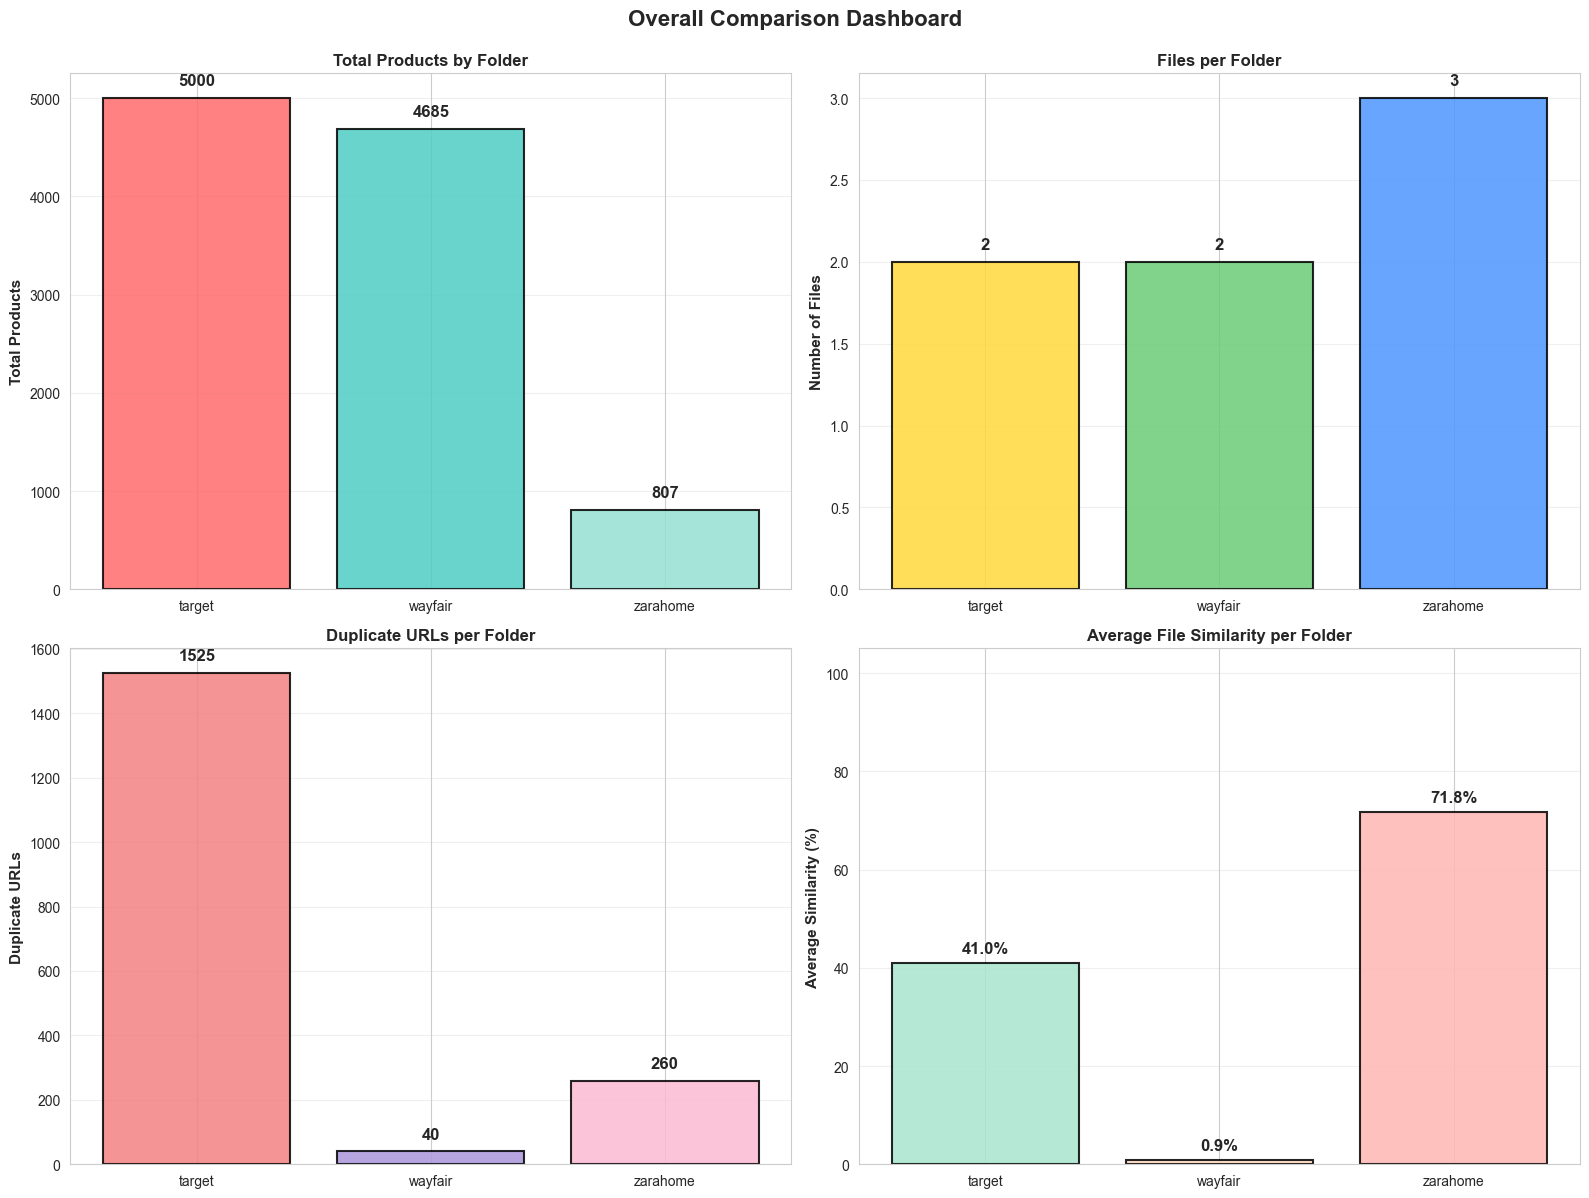

In [57]:
# Create a comprehensive dashboard comparing all folders
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Total products per folder
ax1 = axes[0, 0]
folder_totals = {}
for folder in folders:
    if folder in extracted_data and extracted_data[folder]:
        total = sum(len(products) for products in extracted_data[folder].values())
        folder_totals[folder] = total

if folder_totals:
    bars = ax1.bar(folder_totals.keys(), folder_totals.values(), 
                   color=['#FF6B6B', '#4ECDC4', '#95E1D3'], 
                   edgecolor='black', linewidth=1.5, alpha=0.85)
    for bar, val in zip(bars, folder_totals.values()):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(folder_totals.values())*0.02,
                str(val), ha='center', va='bottom', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Total Products', fontsize=11, fontweight='bold')
    ax1.set_title('Total Products by Folder', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

# 2. Number of files per folder
ax2 = axes[0, 1]
folder_file_counts = {}
for folder in folders:
    if folder in extracted_data and extracted_data[folder]:
        folder_file_counts[folder] = len(extracted_data[folder])

if folder_file_counts:
    bars = ax2.bar(folder_file_counts.keys(), folder_file_counts.values(),
                   color=['#FFD93D', '#6BCB77', '#4D96FF'],
                   edgecolor='black', linewidth=1.5, alpha=0.85)
    for bar, val in zip(bars, folder_file_counts.values()):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(folder_file_counts.values())*0.02,
                str(val), ha='center', va='bottom', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Number of Files', fontsize=11, fontweight='bold')
    ax2.set_title('Files per Folder', fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)

# 3. Duplicate counts per folder
ax3 = axes[1, 0]
folder_duplicates = {}
for folder in folders:
    if folder in extracted_data and extracted_data[folder]:
        url_dups = len(find_duplicates_by_field(folder, 'url'))
        folder_duplicates[folder] = url_dups

if folder_duplicates:
    bars = ax3.bar(folder_duplicates.keys(), folder_duplicates.values(),
                   color=['#F38181', '#AA96DA', '#FCBAD3'],
                   edgecolor='black', linewidth=1.5, alpha=0.85)
    for bar, val in zip(bars, folder_duplicates.values()):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (max(folder_duplicates.values()) or 1)*0.02,
                str(val), ha='center', va='bottom', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Duplicate URLs', fontsize=11, fontweight='bold')
    ax3.set_title('Duplicate URLs per Folder', fontsize=12, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)

# 4. Average similarity per folder
ax4 = axes[1, 1]
folder_avg_sim = {}
for folder in folders:
    if folder in similarity_results:
        sim_matrix, _ = similarity_results[folder]
        n = len(sim_matrix)
        if n > 1:
            avg_sim = sum(sum(row) - 1 for row in sim_matrix) / (n * (n - 1))
            folder_avg_sim[folder] = avg_sim * 100

if folder_avg_sim:
    bars = ax4.bar(folder_avg_sim.keys(), folder_avg_sim.values(),
                   color=['#A8E6CF', '#FFDAC1', '#FFB7B2'],
                   edgecolor='black', linewidth=1.5, alpha=0.85)
    for bar, val in zip(bars, folder_avg_sim.values()):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(folder_avg_sim.values())*0.02,
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Average Similarity (%)', fontsize=11, fontweight='bold')
    ax4.set_title('Average File Similarity per Folder', fontsize=12, fontweight='bold')
    ax4.set_ylim(0, 105)
    ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Overall Comparison Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()